## CNN utilizando o dataset Fashion-Mnist
Este código é para fins de aprendizado, então vou colocar algumas explicações que achei interessantes e relevantes para entender melhor o que está sendo feito.

In [1]:
!pip3 install torch torchvision

## Carregando o Conjunto de Dados

Aqui está um exemplo de como carregar o [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) dataset do TorchVision.
O Fashion-MNIST é um conjunto de imagens de artigos da Zalando, consistindo de 60.000 exemplos de treinamento e 10.000 exemplos de teste.
Cada exemplo é composto por uma imagem em tons de cinza de 28×28 pixels e um rótulo associado a uma das 10 classes.

Nós carregamos o [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) com os seguintes parâmetros:
 - ``root`` é o caminho onde os dados de treino/teste estão armazenados,
 - ``train`` especifica se é o conjunto de dados de treino ou teste,
 - ``download=True`` baixa os dados da internet se não estiverem disponíveis em ``root``.
 - ``transform`` e ``target_transform`` especificam as transformações das características e rótulos

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

torch.manual_seed(17)
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11738135.99it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173423.24it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3178355.53it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4614720.45it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Iterando e Visualizando o Conjunto de Dados

Podemos indexar os ``Datasets`` manualmente como uma lista: ``training_data[index]``.
Usamos o ``matplotlib`` para visualizar algumas amostras em nossos dados de treinamento.

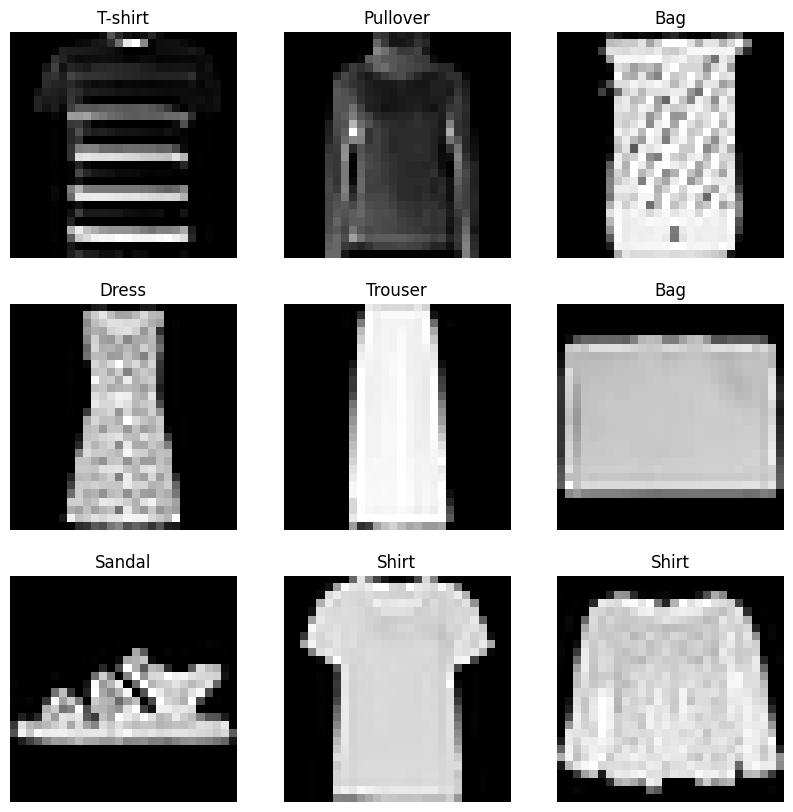

In [3]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):  # realizará o plot de 9 imagens, com 3 imagens por linha (3 linhas)
    sample_idx = torch.randint(len(training_data), size = (1,)).item() #Essa linha de código cria um índice aleatório para acessar um exemplo aleatório do conjunto de dados de treinamento.
    image, label = training_data[sample_idx]  #cada item dos dados de treino contem o tensor que representa a imagem, e a classificação da imagem (das 10 definidas na labels_map)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

## Preparando os dados para treinamento com DataLoaders
O ``Dataset`` recupera as características e rótulos do nosso conjunto de dados um exemplo de cada vez. Ao treinar um modelo, normalmente queremos passar amostras em "minibatches", reorganizar (shuffle) os dados a cada época para reduzir o overfitting do modelo e usar o ``multiprocessing`` do Python para acelerar a recuperação de dados.

``DataLoader`` é um iterável que abstrai essa complexidade para nós em uma API fácil.







In [4]:

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterar através do DataLoader

Nós carregamos o conjunto de dados no ``DataLoader`` e podemos iterar pelo conjunto de dados conforme necessário.
Cada iteração abaixo retorna um conjunto de ``train_features`` e ``train_labels`` (contendo respectivamente ``batch_size=64`` *features* e rótulos).
Porque especificamos ``shuffle=True``, depois de iterar por todos os batches os dados são embaralhados (para um controle mais detalhado sobre a ordem de carregamento dos dados, dê uma olhada nos [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


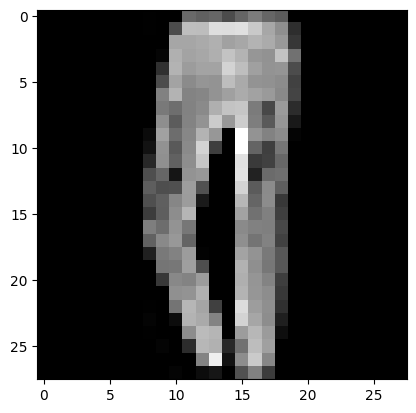

Label: Trouser


In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader)) #permite acessar um único batch de dados de treinamento, este batch tem 64 features em conjunto com suas respectivas 'labels'
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[3].squeeze()  #qualquer numero de 0 a 63 retorna uma imagem com seu respectivo rótulo, pode testar.
label = train_labels[3]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {labels_map[int(label)]}")

## Criando o Modelo
O básico para se criar um modelo de rede neural convolucional pode ser encontrado neste link:
https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html


Para definir uma rede convolucional no PyTorch, criamos uma classe que herda de ``nn.Module``. As camadas da rede são então definidas dentro da função ``init`` e especificam como os dados passarão pela rede na função ``forward``. Se a GPU estiver disponível, movemos a rede para lá para acelerar as operações na rede neural.

Mais detalhes sobre como cada camada funciona no link:
https://pytorch.org/docs/stable/nn.html


Nosso teste será com o modelo da ***Resnet 18***, que tem boa eficiência em questões de número de parâmetros, operações e acurácia. Vamos ver como esse modelo se sai para a *Fashion Mnist*.


In [6]:
#define the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)



1.   Definimos um bloco básico de construção da ResNet18. Ele difere um pouco das arquiteturas maiores da ResNet, mas a lógica geral é a mesma. O bloco consiste em duas camadas convolucionais e suporta *skip connections*.



In [7]:
class Block(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        # Na classe do modelo para a resnet 18 ficará claro este trecho do código, que é a peça fundamental para as skip connections.
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

2.   Definimos a arquitetura principal para a ResNet18. Como já foi  visto, temos inicialmente uma camada convolucional simples, e quatro **blocos residuais** definidos pela classe feita anteriormente. No final, usamos um *adaptative average pooling* (para o modelo ser agnóstico ao tamanho da imagem de entrada) e uma camada *fully connected*.

In [8]:
class ResNet_18(nn.Module):

    def __init__(self, image_channels, num_classes):

        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3) #no nosso caso as imagens tem apenas 1 canal
        self.bn1 = nn.BatchNorm2d(64) #normaliza nosso batch, teoricamente isso nos ajuda a executar o treinamento dos parâmetros
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1) #qtd de canais de entrada, qtd de canais de saida, e stride dessa operação
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def __make_layer(self, in_channels, out_channels, stride):

        identity_downsample = None
        if stride != 1:   # Se o stride for diferente de 1, isto implica na mudança de dimensões entre uma camada e outra.
            identity_downsample = self.identity_downsample(in_channels, out_channels)
             # a função identity_downsample é chamada para criar a skip connection ajustando
             #as dimensões do tensor de entrada para que possa ser somado ao tensor de saída
             #do bloco convolucional de forma correta.

        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride),
            Block(out_channels, out_channels)
        )

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)  # retorna um tensor com o numero de classes definido pro modelo
        return x

    def identity_downsample(self, in_channels, out_channels):
    # A função identity_downsample é uma sequência de camadas convolucionais e de normalização que
    #ajustam as dimensões espaciais do tensor de entrada para que correspondam às dimensões do tensor
    #de saída do bloco convolucional. Ela faz o ajuste das dimensões
    #diminuindo pela metade a largura e a altura (devido ao stride=2) e dobra o número de canais
    #para corresponder ao canal de saída.

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels)
        )

3.   Criamos o modelo com 1 canal de imagem (nosso caso para o *Fashion Mnist*, e 10 classes diferentes.

In [9]:
model = ResNet_18(1, 10)

#parametros treinaveis do modelo:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

12556426

In [10]:
#move the model to the device
model.to(device)
next(model.parameters()).is_cuda

True

4.   Chegou a hora de treinar a rede, definimos tudo o que precisamos e aplicamos na função de validação e treino do nosso modelo.

In [14]:
from torch import optim
#definindo tudo que precisamos para o treino da resnet
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)  # útil para ajustar automaticamente a taxa de aprendizado durante o treinamento

In [12]:


def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, is_inception=False):

    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data

                inputs = transforms.functional.resize(inputs, (112, 112))
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train': # Backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)

            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [15]:
model, _ = train_model(model, {"train": train_dataloader, "val": test_dataloader}, criterion, optimizer, epochs)

Epoch 0/49
----------
train Loss: 0.0384 Acc: 0.9862
val Loss: 0.2983 Acc: 0.9248

Epoch 1/49
----------
train Loss: 0.0376 Acc: 0.9868
val Loss: 0.2965 Acc: 0.9254

Epoch 2/49
----------
train Loss: 0.0349 Acc: 0.9879
val Loss: 0.3277 Acc: 0.9195

Epoch 3/49
----------
train Loss: 0.0299 Acc: 0.9896
val Loss: 0.3019 Acc: 0.9230

Epoch 4/49
----------
train Loss: 0.0269 Acc: 0.9901
val Loss: 0.2996 Acc: 0.9264

Epoch 5/49
----------
train Loss: 0.0258 Acc: 0.9907
val Loss: 0.3225 Acc: 0.9235

Epoch 6/49
----------
train Loss: 0.0253 Acc: 0.9912
val Loss: 0.3818 Acc: 0.9080

Epoch 7/49
----------
train Loss: 0.0239 Acc: 0.9918
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
val Loss: 0.4219 Acc: 0.9087

Epoch 8/49
----------
train Loss: 0.0071 Acc: 0.9984
val Loss: 0.2847 Acc: 0.9357

Epoch 9/49
----------
train Loss: 0.0020 Acc: 0.9999
val Loss: 0.2936 Acc: 0.9371

Epoch 10/49
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.3080 Acc: 0.9370

Epoch 11/49
----------
t

In [ ]:
#resultados obtidos com 15 epochs:
  # train Loss: 0.3492 Acc: 0.8729
  # val Loss: 0.2519 Acc: 0.9104

  # Epoch 1/14
  # ----------
  # train Loss: 0.2206 Acc: 0.9196
  # val Loss: 0.2230 Acc: 0.9202

  # Epoch 2/14
  # ----------
  # train Loss: 0.1783 Acc: 0.9354
  # val Loss: 0.2832 Acc: 0.8996

  # Epoch 3/14
  # ----------
  # train Loss: 0.1480 Acc: 0.9454
  # val Loss: 0.2175 Acc: 0.9245

  # Epoch 4/14
  # ----------
  # train Loss: 0.1199 Acc: 0.9562
  # val Loss: 0.2296 Acc: 0.9231

  # Epoch 5/14
  # ----------
  # train Loss: 0.0972 Acc: 0.9636
  # val Loss: 0.3085 Acc: 0.9023

  # Epoch 6/14
  # ----------
  # train Loss: 0.0782 Acc: 0.9713
  # val Loss: 0.2418 Acc: 0.9269

  # Epoch 7/14
  # ----------
  # train Loss: 0.0646 Acc: 0.9765
  # val Loss: 0.3188 Acc: 0.9095

  # Epoch 8/14
  # ----------
  # train Loss: 0.0519 Acc: 0.9810
  # val Loss: 0.3189 Acc: 0.9141

  # Epoch 9/14
  # ----------
  # train Loss: 0.0480 Acc: 0.9831
  # Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
  # val Loss: 0.2605 Acc: 0.9276

  # Epoch 10/14
  # ----------
  # train Loss: 0.0140 Acc: 0.9963
  # val Loss: 0.2478 Acc: 0.9370

  # Epoch 11/14
  # ----------
  # train Loss: 0.0043 Acc: 0.9996
  # val Loss: 0.2650 Acc: 0.9381

  # Epoch 12/14
  # ----------
  # train Loss: 0.0022 Acc: 0.9999
  # val Loss: 0.2791 Acc: 0.9391

  # Epoch 13/14
  # ----------
  # train Loss: 0.0015 Acc: 0.9999
  # val Loss: 0.3003 Acc: 0.9367

  # Epoch 14/14
  # ----------
  # train Loss: 0.0009 Acc: 1.0000
  # val Loss: 0.3140 Acc: 0.9359

  # Training complete in 18m 22s
  # Best val Acc: 0.939100


#Proxima tentativa com 50 epochs...

## Conclusão

Ao comparar a **resnet 18** feita aqui com outros classificadores disponíveis no [benchmark](https://github.com/zalandoresearch/fashion-mnist), o modelo se sai muito bem, apesar de ter classificadores apresentados com uma quantidade muito menor de parâmetros (~100K) que tiveram mesma ou melhor acurácia que a resnet, já que ela é uma rede mais profunda, que pode ser usada para uma gama maior de problemas e classificações.

Quanto ao treinamento da rede, apenas 15 *epochs* parece ser suficiente para obter uma boa acurácia sem gastar tanto tempo de compilação, a acurácia fica estagnada quando chega próxima aos $94\%$.


## Referências e links usados neste Notebook


*  https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch

*  https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

*  https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#loading-a-dataset

*  https://github.com/zalandoresearch/fashion-mnist

*  https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/